# <b> 5. Feature Selection<b/>

### <b>Import needed libraries</b>

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('..'))
#### FEATURE SELECTION
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.linear_model import LogisticRegression 

import warnings
warnings.filterwarnings('ignore')


## <b> 5.1 Using Train Dataset<b/>

In [52]:
df_train = pd.read_csv('C:/Users/P058886/Downloads/HR_Attrition_Train_Dataset.csv')

### <b> 5.1.1 Preprocessing</b>

In [53]:
df_train

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,47,No,Travel_Rarely,1225,Sales,2,4,Life Sciences,1,1676,...,3,80,3,29,2,3,3,2,1,2
1,22,No,Travel_Rarely,594,Research & Development,2,1,Technical Degree,1,169,...,3,80,1,3,2,3,2,1,2,1
2,46,No,Travel_Rarely,406,Sales,3,1,Marketing,1,1124,...,4,80,1,23,3,3,12,9,4,9
3,25,No,Travel_Rarely,622,Sales,13,1,Medical,1,645,...,3,80,0,7,1,3,7,4,0,6
4,43,No,Travel_Frequently,1001,Research & Development,9,5,Medical,1,663,...,2,80,1,10,3,3,8,7,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,23,Yes,Travel_Rarely,427,Sales,7,3,Life Sciences,1,1702,...,2,80,1,3,2,3,3,2,0,2
1172,38,No,Travel_Rarely,1009,Sales,2,2,Life Sciences,1,1355,...,4,80,1,11,3,3,7,7,1,7
1173,22,No,Travel_Rarely,217,Research & Development,8,1,Life Sciences,1,1019,...,1,80,1,4,3,2,4,3,1,1
1174,36,No,Travel_Rarely,430,Research & Development,2,4,Other,1,1847,...,4,80,1,15,2,3,1,0,0,0


In [54]:
# Outliers
def treat_outliers_iqr(df_train, cols, verbose=True):
    
    report = []

    for col in cols:
        if col not in df_train.columns:
            print(f"⚠️ Column '{col}' not found in DataFrame.")
            continue

        # Calculate IQR limits
        Q1 = df_train[col].quantile(0.25)
        Q3 = df_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

        # Count outliers before clipping
        count_before = ((df_train[col] < lower) | (df_train[col] > upper)).sum()

        # Apply clipping
        df_train[col] = np.clip(df_train[col], lower, upper)

        # Count outliers after clipping
        count_after = ((df_train[col] < lower) | (df_train[col] > upper)).sum()

        # Save results
        report.append({
            "Column": col,
            "Q1": round(Q1, 3),
            "Q3": round(Q3, 3),
            "IQR": round(IQR, 3),
            "Lower Limit": round(lower, 3),
            "Upper Limit": round(upper, 3),
            "Outliers Before": count_before,
            "Outliers After": count_after,
            "% Changed": round(100 * (count_before - count_after) / len(df_train), 2)
        })

        if verbose:
            print(f"{col}: {count_before} → {count_after} outliers (treated {count_before - count_after})")

    report_df = pd.DataFrame(report)
    return df_train, report_df


In [55]:
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns
num_cols = df_train.select_dtypes(include=['number']).columns

print("Categorical columns:", cat_cols.tolist())
print("Numeric columns:", num_cols.tolist())


Categorical columns: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
Numeric columns: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [56]:
cols_to_drop = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
df_train = df_train.drop(columns=cols_to_drop)

In [57]:
cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender',
            'JobRole', 'MaritalStatus', 'OverTime']

num_cols = df_train.select_dtypes(include=['number']).columns
print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols.tolist())

Categorical columns: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Numeric columns: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [58]:
target_col = 'Attrition'
X = df_train.drop(columns=[target_col])   # all columns except target
y = df_train[target_col].map({'Yes': 1, 'No': 0})  # encode target as 1/0

In [61]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [62]:
# Check the shape of the splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (940, 30)
X_test shape: (236, 30)
y_train shape: (940,)
y_test shape: (236,)


### <b>Filter Method</b>

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import pandas as pd

def select_top_features(X, y, k=20, score_func=mutual_info_classif):
    """
    Selects the top k features using mutual information.
    Works with both numeric and categorical features.
    """

    # Convert categorical columns to category dtype (for safety)
    X = X.copy()
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = X[col].astype('category').cat.codes  # encode internally as integers

    # Apply feature selection
    selector = SelectKBest(score_func=score_func, k=k)
    X_selected = selector.fit_transform(X, y)

    # Extract feature names and scores
    feature_names = X.columns[selector.get_support()]
    scores = selector.scores_[selector.get_support()]

    feature_scores = (
        pd.DataFrame({'Feature': feature_names, 'Score': scores})
        .sort_values(by='Score', ascending=False)
        .reset_index(drop=True)
    )

    X_selected_df = pd.DataFrame(X_selected, columns=feature_names, index=X.index)

    return X_selected_df, feature_scores


# == Print the outputs ===
X_selected, feature_scores = select_top_features(X, y, k=20)

print("✅ Top features selected:")
print(feature_scores.head(10))
print("\nShape of reduced dataset:", X_selected.shape)

✅ Top features selected:
                Feature     Score
0              JobLevel  0.038262
1         MonthlyIncome  0.036764
2               JobRole  0.031785
3     TotalWorkingYears  0.030346
4      StockOptionLevel  0.026022
5        JobInvolvement  0.023365
6              OverTime  0.022488
7        BusinessTravel  0.022122
8  YearsWithCurrManager  0.020602
9        YearsAtCompany  0.019240

Shape of reduced dataset: (1176, 20)


In [67]:
# Combine features and target temporarily
df_corr = X_selected.copy()
df_corr['Attrition'] = y  # Add target back

# Compute correlations with Attrition
corr_with_target = df_corr.corr()['Attrition'].drop('Attrition').sort_values(key=abs, ascending=False)

print("🔍 Correlation of features with Attrition:")
print(corr_with_target.head(10))

🔍 Correlation of features with Attrition:
OverTime                0.214389
TotalWorkingYears      -0.186154
Age                    -0.185269
YearsWithCurrManager   -0.168789
YearsInCurrentRole     -0.167028
JobLevel               -0.166245
MonthlyIncome          -0.160438
YearsAtCompany         -0.155139
MaritalStatus           0.152757
StockOptionLevel       -0.142803
Name: Attrition, dtype: float64


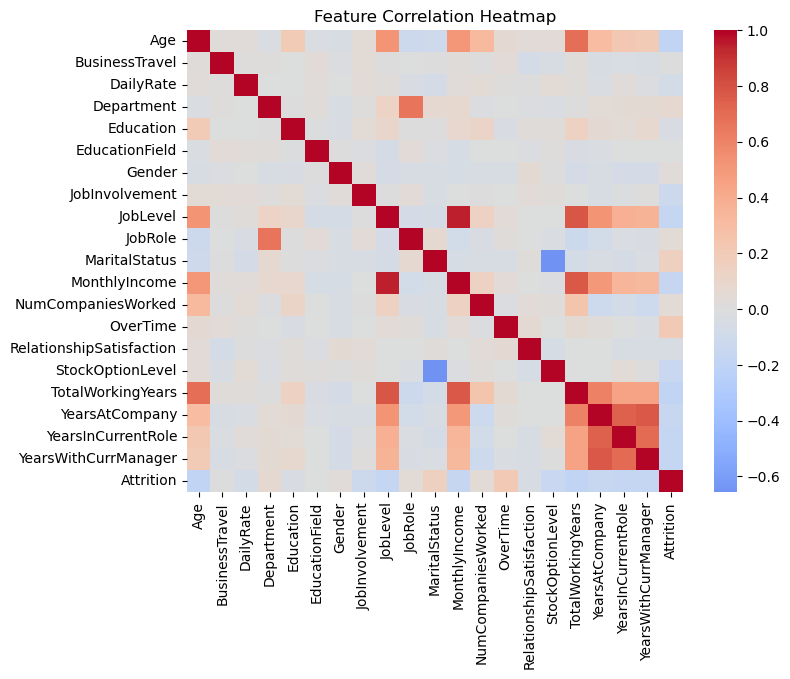

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr.corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()
